In [22]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten,Dropout,Conv2D
from keras.layers import LSTM
from keras.layers import Reshape
from sklearn.model_selection import train_test_split
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
# get the raw sequence
def input_file(file_path):
    """
    input is the path of fasta file
    output is a list of sequences
    """
    sequences = []
    current_sequence = ""

    with open(fasta_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_sequence:
                    sequences.append(current_sequence)
                    current_sequence = ""
            else:
                current_sequence += line

    if  current_sequence:
        sequences.append(current_sequence)
    
    return sequences

In [24]:
# one hot encoding for the input
def one_hot_encode(seq):
    """
    input is the individual sequence
    output is the individual one-hot-encoded sequence
    """
    map = np.asarray([[1,0,0,0,0],
                      [0,1,0,0,0],
                      [0,0,1,0,0],
                      [0,0,0,1,0],
                      [0,0,0,0,1]])
    # replace ATCG with corresponding numbers
    seq = seq.upper().replace('A','\x00').replace('C','\x01').replace('G', '\x02').replace('T', '\x03').replace('N','\x04')
    seq_array = np.fromstring(seq, np.int8)
    seq_array = seq_array % 5
    encoded_seq = map[seq_array]
    
    return encoded_seq
    

In [25]:
# pad the sequence and get the input
def process_input(sequences,chunk_size):
    """
    To ensure every sequence has the same length, I pad the sequence with "N" up to the length of set chunk_size
    Then encode every sequence to get the final input for the model
    input: a list of raw sequences and chunk size
    output: the input of model (X)
    """
    padded_seq = []
    pad = ''
    for seq in sequences:
        pad = seq.ljust(chunk_size, 'N')
        padded_seq.append(pad)

    one_hot_sequences = [one_hot_encode(seq) for seq in padded_seq]
    seq_array = np.array(one_hot_sequences)
    one_hot_length = 5
    X = seq_array.reshape(-1, chunk_size, one_hot_length)
    return X

In [26]:
# translate sequence to VDJ sequence
def translate_output(df,idx):
    """
    input: the path of annotation file and the index of each item (sequence)
    output: the individual VDJ sequence like "VVVVVDDDJJJ"
    """
    # store the start, end position and length of VDJ
    # the start and end
    positions = {
    'V': [df.loc[idx, 'v_sequence_start'] - 1, df.loc[idx, 'v_sequence_end']-1],
    'D': [df.loc[idx, 'd_sequence_start'] - 1, df.loc[idx, 'd_sequence_end']-1],
    'J': [df.loc[idx, 'j_sequence_start'] - 1, df.loc[idx, 'j_sequence_end']-1],
    }
    # the length 
    for key in positions.keys():
        positions[key].append(positions[key][1] - positions[key][0]+1)
    
    # create sequence
    seq = ['X'] * (positions['J'][1] + 1)
    
    # replace the X with VDJN 
    for key, (start, end, length) in positions.items():
        seq[start:end+1] = [key] * length
    my_seq = ''.join(seq)
    my_seq = my_seq.replace('X', 'N')
    my_seq = my_seq.ljust(chunk_size, 'X')
    
    return my_seq
        

In [27]:
# one-hot-encoding for the output
def output_encoding(seq):
    """
    input: the individual VDJ sequence
    output: the individual encoded sequence
    """
    map = np.asarray([[1,0,0,0,0],
                      [0,1,0,0,0],
                      [0,0,1,0,0],
                      [0,0,0,1,0],
                      [0,0,0,0,1]])
   # replace VDJN with corresponding numbers
    seq = seq.upper().replace('V','\x00').replace('D','\x01').replace('J', '\x02').replace('N', '\x03').replace('X','\x04')
    seq_array = np.fromstring(seq, np.int8)
    seq_array = seq_array % 5
    encoded_seq = map[seq_array]
    
    return encoded_seq

In [28]:
# get the output
def process_output(df):
    """
    input: the dataframe obtained from the annotation file
    output: the one-hot-encoded target label of the model
    """
    encoded_VDJ = []
    num_VDJ = []
    for i in range(len(df)):
        seq = translate_output(df,i)
        seq_num = output_catogory(seq)
        
        num_VDJ.append(seq_num)
        encoded_seq = output_encoding(seq)
        encoded_VDJ.append(encoded_seq)
        
    y = np.array(encoded_VDJ)
    y_class = np.array(num_VDJ)
    
    return y, y_class


In [29]:
# translate the VDJ sequence to 1,2,3,4 for performance evaluation
def output_catogory(seq):
    """
    input is the individual VDJ sequence
    output is a list of numbers including 0,1,2,3,4, which respectively correspond to VDJNX
    """
    seq = seq.replace('V','\x00').replace('D','\x01').replace('J', '\x02').replace('N', '\x03').replace('X','\x04')
    return np.fromstring(seq, np.int8)

In [30]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## input and output

In [31]:
fasta_file = os.path.join('..','repertoire','bigger','bigger_10000.fasta')
sequences = input_file(fasta_file)
chunk_size = 450
X = process_input(sequences, chunk_size)
print(X.shape)
print(X)

(10000, 450, 5)
[[[0 0 1 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[0 1 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[0 1 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 ...

 [[0 1 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[0 0 1 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[0 1 0 0 0]
  [1 0 0 0 0]
  [0 0 1 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]]


/tmp/ipykernel_478837/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [32]:
annotation_file = os.path.join('..','repertoire','bigger','bigger_10000.tsv')
df = pd.read_csv(annotation_file, sep='\t', header=0)
y,y_class = process_output(df)
print(y.shape)
print(y_class.shape)
print(y)

/tmp/ipykernel_478837/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_478837/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


(10000, 450, 5)
(10000, 450)
[[[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 ...

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]

 [[1 0 0 0 0]
  [1 0 0 0 0]
  [1 0 0 0 0]
  ...
  [0 0 0 0 1]
  [0 0 0 0 1]
  [0 0 0 0 1]]]


## build the model

In [33]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("GPU device:", gpu)
        print("number of GPU device: ",len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU devices found.")


tf.config.experimental.set_memory_growth(gpus[0], True)


GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
number of GPU device:  1


In [34]:
import time
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [35]:
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [43]:
# create the model
sequence_length = chunk_size
one_hot_length = 5
input_shape = (sequence_length, one_hot_length)
num_classes = 5

model = Sequential()
model.add(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
model.add(Dropout(0.5))

model.add(Conv1D(filters=8, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=1))

model.add(Flatten())
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(450*5, activation='softmax'))
model.add(Reshape((450,5)))
model.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=0.0001), metrics=['accuracy'])
print(model.summary())

start_time = time.time()
log_dir = "logs/CNNonshm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=18, batch_size=32, callbacks=[tf_callback])
end_time = time.time()
training_time = end_time - start_time
print("Training the model took {:.2f} seconds".format(training_time))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 450, 16)           176       
                                                                 
 dropout_14 (Dropout)        (None, 450, 16)           0         
                                                                 
 conv1d_15 (Conv1D)          (None, 450, 8)            264       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 450, 8)           0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 3600)              0         
                                                                 
 dense_14 (Dense)            (None, 32)                115232    
                                                      

2023-08-03 16:57:20.528538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [7000,450,5]
	 [[{{node Placeholder/_11}}]]
2023-08-03 16:57:20.528653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [7000,450,5]
	 [[{{node Placeholder/_11}}]]


219/219 [==============================] - 1s 2ms/step - loss: 0.6197 - accuracy: 0.7667 - val_loss: 0.1531 - val_accuracy: 0.9362
Epoch 2/18
 43/219 [====>.........................] - ETA: 0s - loss: 0.2097 - accuracy: 0.9232

2023-08-03 16:57:21.370004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [3000,450,5]
	 [[{{node Placeholder/_11}}]]
2023-08-03 16:57:21.370139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype int64 and shape [3000,450,5]
	 [[{{node Placeholder/_11}}]]


219/219 [==============================] - 0s 1ms/step - loss: 0.1916 - accuracy: 0.9257 - val_loss: 0.1465 - val_accuracy: 0.9362
Epoch 3/18
219/219 [==============================] - 0s 1ms/step - loss: 0.1669 - accuracy: 0.9304 - val_loss: 0.1441 - val_accuracy: 0.9365
Epoch 4/18
219/219 [==============================] - 0s 1ms/step - loss: 0.1560 - accuracy: 0.9333 - val_loss: 0.1429 - val_accuracy: 0.9361
Epoch 5/18
219/219 [==============================] - 0s 1ms/step - loss: 0.1507 - accuracy: 0.9349 - val_loss: 0.1420 - val_accuracy: 0.9367
Epoch 6/18
219/219 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9360 - val_loss: 0.1408 - val_accuracy: 0.9383
Epoch 7/18
219/219 [==============================] - 0s 1ms/step - loss: 0.1449 - accuracy: 0.9366 - val_loss: 0.1383 - val_accuracy: 0.9370
Epoch 8/18
219/219 [==============================] - 0s 1ms/step - loss: 0.1410 - accuracy: 0.9381 - val_loss: 0.1314 - val_accuracy: 0.9417
Epoch 9/18
219/21

In [44]:
y_pred = model.predict(X_test)
y_pred[0]

94/94 [==============================] - 0s 459us/step


2023-08-03 16:57:29.730771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64 and shape [3000,450,5]
	 [[{{node Placeholder/_10}}]]
2023-08-03 16:57:29.730885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype int64 and shape [3000,450,5]
	 [[{{node Placeholder/_10}}]]


array([[3.79226543e-03, 2.70252570e-11, 5.73298187e-10, 1.79708548e-12,
        3.23557951e-11],
       [1.52311416e-03, 4.63474224e-12, 1.67369556e-11, 2.13550601e-11,
        7.03083685e-12],
       [1.42058427e-03, 6.75796086e-11, 2.96634550e-10, 2.10543596e-11,
        3.00428293e-11],
       ...,
       [6.31809952e-11, 8.49013047e-12, 7.30952018e-12, 7.31534971e-12,
        2.18306828e-04],
       [1.56306176e-10, 4.51876904e-12, 1.28797736e-11, 2.75456524e-12,
        2.79928558e-04],
       [4.22768287e-12, 3.01470134e-11, 1.08721825e-11, 1.86239756e-11,
        1.71368557e-03]], dtype=float32)

## Evaluation

In [45]:
pred_classes = np.argmax(y_pred, axis=-1)
print(pred_classes[0])
print(pred_classes.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4]
(3000, 450)


In [46]:
y_true = np.argmax(y_test,axis=-1)
print(y_true[0])
print(y_true.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4]
(3000, 450)


([<matplotlib.axis.YTick at 0x7fcb0830f590>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

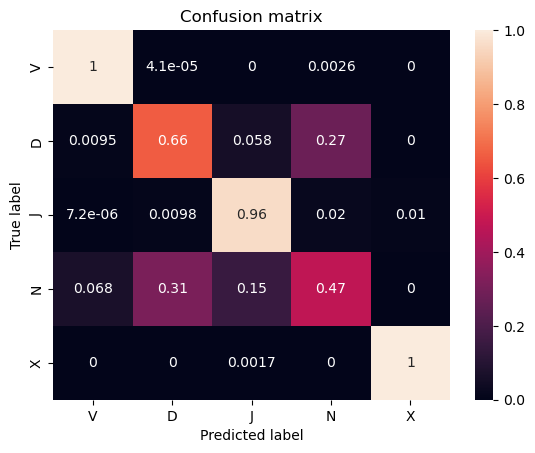

In [47]:
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N', 'X'])
labels = ['V', 'D', 'J', 'N', 'X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

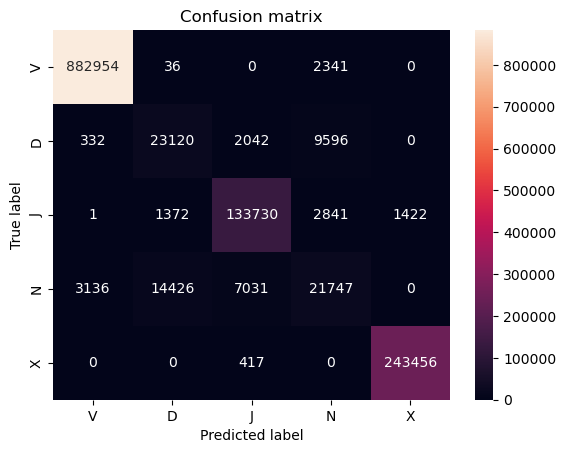

In [48]:
plt.figure()
sns.heatmap(cm, annot=True, fmt="d")

labels = ['V', 'D', 'J', 'N', 'X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [50]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9666718518518519
Precision: 0.8225877646687021
Recall: 0.8166668607373623
F1 Score: 0.8177564165091237


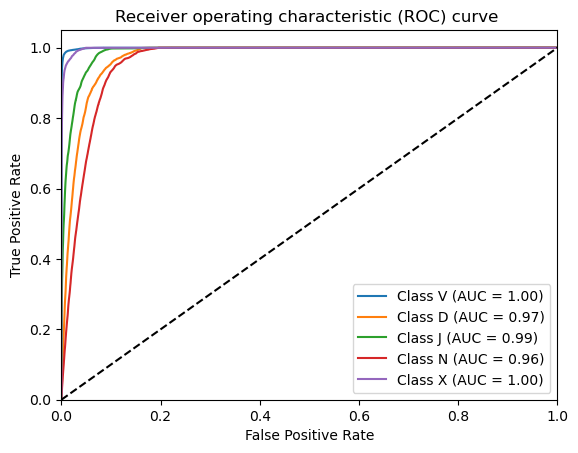

In [53]:
vdjclass = ["V","D","J","N","X"]
plt.figure()
for i in range(5):
    y_pred_1d = y_pred[:,:,i].ravel()
    y_true_1d = y_test[:,:,i].ravel()
    fpr, tpr, _ = roc_curve(y_true_1d, y_pred_1d)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='Class %s (AUC = %0.2f)' % (vdjclass[i],roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve ')
plt.legend(loc="lower right")
plt.show()